# Training procces and image analysis FireFly App





## Install FalconCV



In [ ]:
%tensorflow_version 1.x

In [ ]:
!pip install tf_slim
!pip uninstall falconcv -y && pip install git+https://github.com/haruiz/FalconCV.git

  Cloning https://github.com/haruiz/FalconCV.git to /tmp/pip-req-build-9bs5oh18
  Running command git clone -q https://github.com/haruiz/FalconCV.git /tmp/pip-req-build-9bs5oh18
  Created wheel for falconcv: filename=falconcv-1.0.23-cp36-none-any.whl size=47322 sha256=8dedbd1ac47e70bd27901e70174519751491e60ba5ccbd99c62359faf7c092bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-dht1nr2v/wheels/8d/ff/ed/b0c560d97a9c6b14655c25e4cc71a0c29dcea15a7c27924fa5
Successfully built falconcv


# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from pathlib import Path
from falconcv.models import ModelBuilder
from falconcv.models.tf import ModelZoo
from falconcv.util import FileUtil, ColorUtil, VIUtil

import json
import matplotlib.pylab as plt
import more_itertools
import itertools
import cv2
import numpy as np
from mako.template import Template
from PIL import Image, ImageDraw

In [ ]:
images_folder = "/content/drive/My Drive/Colab_Notebooks/Smoke_Masks2/"
model_folder = "/content/drive/My Drive/Colab_Notebooks/"

# Util functions

We defined a funtion that is in agreement with the cvstudio annotation format to generate the xml archives, that are required for the Falconcv program.

In [ ]:
   
def export_to_pascalvoc(img_path, output_folder, img_annotations):
    str_template = '''
        <annotation>
            <folder>${folder}</folder>
            <filename>${filename}</filename>
            <path>${path}</path>
            <source>
                <database>Unknown</database>
            </source>
            <size>
                <width>${width}</width>
                <height>${height}</height>
                <depth>${depth}</depth>
            </size>
            <segmented>0</segmented>
            % for i, region in enumerate(annotations):
                <object>
                    <name>${region["name"]}</name>
                    <pose>Unspecified</pose>
                    <truncated>0</truncated>
                    <difficult>0</difficult>
                    <bndbox>
                        <xmin>${region["xmin"]}</xmin>
                        <ymin>${region["ymin"]}</ymin>
                        <xmax>${region["xmax"]}</xmax>
                        <ymax>${region["ymax"]}</ymax>
                    </bndbox>
                </object>
            % endfor
        </annotation>
        '''
    img_path = Path(img_path)
    img_name = img_path.name
    img_stem = img_path.stem
    img: Image = Image.open(str(img_path))
    w, h = img.size
    c = len(img.getbands())

    xml_str = Template(str_template).render(
        path=img_path,
        folder=str(img_path.parent),
        filename=img_name,
        width=w,
        height=h,
        depth=c,
        annotations=img_annotations)
    output_file = output_folder.joinpath("{}.xml".format(img_stem))
    with open(output_file, 'w') as f:
        f.write(xml_str)



images_folder = Path("/content/drive/My Drive/Smoke_Masks2")
json_file = images_folder.joinpath("annotations.json")
with open(json_file) as f:
    annotations  = json.load(f)


# annotations = sorted(annotations, key=lambda img: img["image"])
# annotations = itertools.groupby(annotations, key=lambda img: img["image"])
# for image_path, img_annots in annotations:    
#     list_annotations = []
#     image_path = images_folder.joinpath(Path(image_path).name)    
#     for annot in img_annots:    
#         polygonPoints = list(map(int,annot["annot_points"].split(",")))    
#         polygonPoints = list(more_itertools.chunked(polygonPoints, 2))
#         polygonPoints = np.array(polygonPoints)    
#         boundingBox = cv2.boundingRect(polygonPoints)
#         # cv2.rectangle(image_array,(x, y),(x+w,y+h),color=(0,255,0))
#         # cv2.fillConvexPoly(image_array, polygonPoints, color=(0,255,0))
#         # plt.imshow(image_array)
#         # plt.show()    
#         x,y, w, h = boundingBox
#         list_annotations.append({
#             "name":annot["label_name"],
#             "xmin":x,
#             "ymin":y,
#             "xmax":x+w,
#             "ymax":y+h
#         })
#     print(image_path)
#     export_to_pascalvoc(image_path, images_folder,list_annotations)

# Train the model

In [ ]:
from falconcv.models import ModelBuilder

if __name__ == '__main__':
    config = {
        "model": "mask_rcnn_inception_v2_coco",
        "images_folder": images_folder,
        "output_folder": model_folder
    }
    with ModelBuilder.build(config=config) as model:
        model.train(epochs=2000,val_split=0.1,clear_folder=False)

In [ ]:
with ModelBuilder.build(config=config) as model:
    model.freeze(checkpoint=2000)

#Test the model

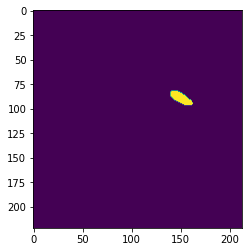

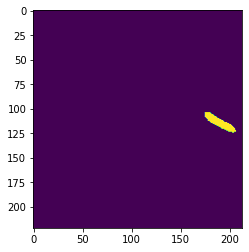

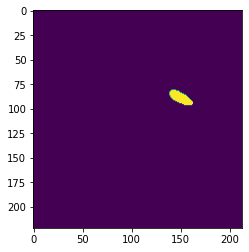

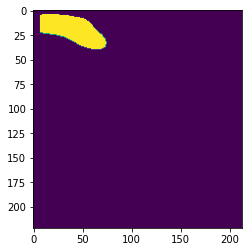

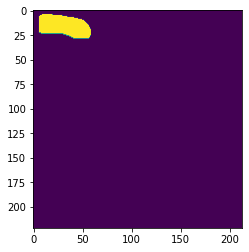

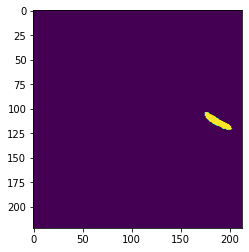

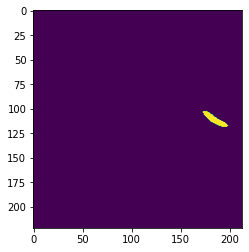

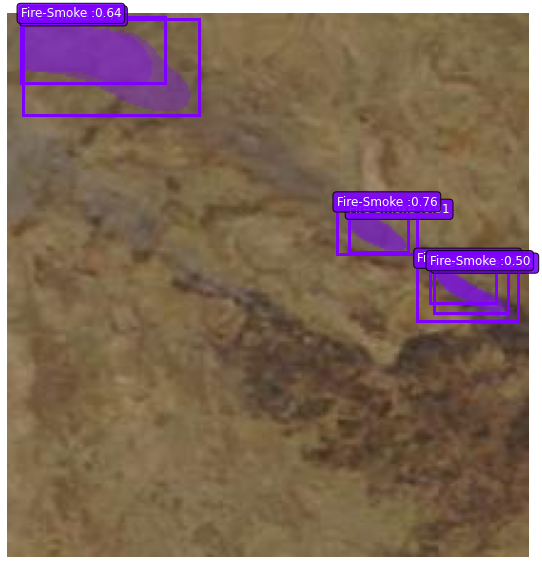

In [ ]:
frozen_model = "/content/drive/My Drive/Colab_Notebooks/mask_rcnn_inception_v2_coco/export/frozen_inference_graph.pb"
labels_map_file = "/content/drive/My Drive/Colab_Notebooks/mask_rcnn_inception_v2_coco/label_map.pbtxt"

#Select the image where you want to find fire smoke
image_path = "/content/drive/My Drive/Colab_Notebooks/Smoke_Masks2/fire1000.jpg"
with ModelBuilder.build(frozen_model,labels_map_file) as model:
    img,predictions=model(image_path, threshold=0.5)
    for mask in predictions:
        plt.imshow(mask.mask)
        plt.show()
    VIUtil.imshow(img,predictions)